# Sudoku Board Capture Tool
A tool for extracting the numbers from an image of a sudoku board and turning it into a matrix. <br/>
Used in conjunction with the digit recognition CNN and the sudoku solver to solve games of sudoku from an image.

---
## Isolating and Transforming the Board

### Imports

In [1]:
import cv2
from imutils import contours
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
from cnn import Net
from solver import solve
from scipy import ndimage

### Isolating the Board

Here's the picture I'm working with:

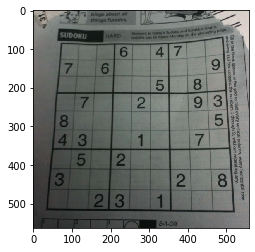

In [2]:
img = cv2.imread('sudoku.jpg')
plt.imshow(img)

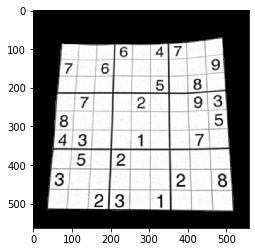

In [3]:
# Grayscale and adaptive threshold

img = cv2.GaussianBlur(img, (5, 5), 0)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros(gray.shape, np.uint8)
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))

close = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel1)
div = np.float32(gray) / close
isolate = np.uint8(cv2.normalize(div, div, 0, 255, cv2.NORM_MINMAX))
res2 = cv2.cvtColor(isolate, cv2.COLOR_GRAY2BGR)
thresh = cv2.adaptiveThreshold(isolate, 255, 0, 1, 19, 2)
_, contour, hier = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Grab the biggest contour (the board)
max_area = 0
best_cnt = None
for cnt in contour:
    area = cv2.contourArea(cnt)
    if area > 50000:
        if area > max_area:
            max_area = area
            best_cnt = cnt

# Isolate board
cv2.drawContours(mask, [best_cnt], 0, 255, -1)
cv2.drawContours(mask, [best_cnt], 0, 0, 2)

isolate = cv2.bitwise_and(isolate, mask)

plt.imshow(isolate, cmap='gray')

### Using a Second Order Derivative Filter to Find the Vertical and Horizontal Lines

#### Vertical lines

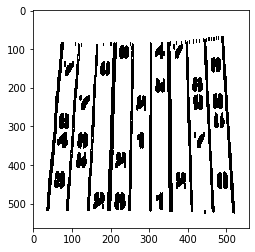

In [4]:
# Obtain vertical contours
kernel_x = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 10))
dx = cv2.Sobel(isolate, cv2.CV_16S, 1, 0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx, dx, 0, 255, cv2.NORM_MINMAX)
_, close = cv2.threshold(dx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
close = cv2.morphologyEx(close, cv2.MORPH_DILATE, kernel_x, iterations=1)

plt.imshow(close, cmap='gray_r')

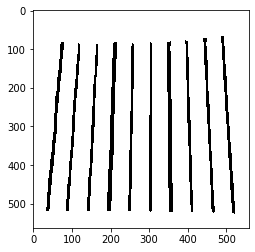

In [5]:
# Remove number contours, isolating vertical lines
_, contour, hier = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contour:
    x, y, w, h = cv2.boundingRect(cnt)
    if h / w > 5:
        cv2.drawContours(close, [cnt], 0, 255, -1)
    else:
        cv2.drawContours(close, [cnt], 0, 0, -1)

close_x = cv2.morphologyEx(close, cv2.MORPH_CLOSE, None, iterations=2)

plt.imshow(close_x, cmap='gray_r')

#### Horizontal lines

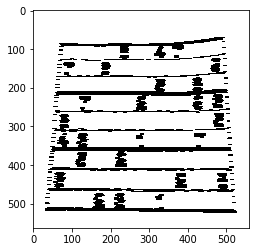

In [6]:
# Obtain horizontal contours
kernel_y = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 2))
dy = cv2.Sobel(isolate, cv2.CV_16S, 0, 2)
dy = cv2.convertScaleAbs(dy)
cv2.normalize(dy, dy, 0, 255, cv2.NORM_MINMAX)
ret, close = cv2.threshold(dy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
close = cv2.morphologyEx(close, cv2.MORPH_DILATE, kernel_y)

plt.imshow(close, cmap='gray_r')

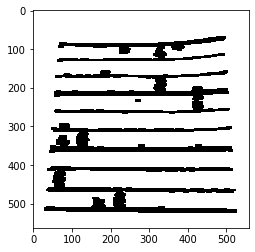

In [7]:
# Remove number contours, isolating vertical lines
_, contour, _ = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contour:
    x, y, w, h = cv2.boundingRect(cnt)
    if w / h > 5:
        cv2.drawContours(close, [cnt], 0, 255, -1)
    else:
        cv2.drawContours(close, [cnt], 0, 0, -1)

close_y = cv2.morphologyEx(close, cv2.MORPH_DILATE, None, iterations=2)

plt.imshow(close_y, cmap='gray_r')

### Obtaining centroids and applying perspective transform

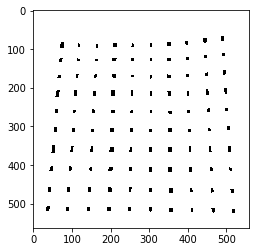

In [8]:
# Get intersections
isolate = cv2.bitwise_and(close_x, close_y)
plt.imshow(isolate, cmap='gray_r')

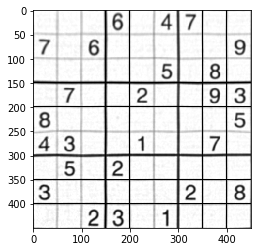

In [9]:
# Obtain centroids
_, contour, _ = cv2.findContours(isolate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
centroids = []
for cnt in contour:
    mom = cv2.moments(cnt)
    (x, y) = int(mom['m10'] / mom['m00']), int(mom['m01'] / mom['m00'])
    cv2.circle(img, (x, y), 4, (0, 255, 0), -1)
    centroids.append((x, y))

# Re-order centroids
centroids = np.array(centroids, dtype=np.float32)
c = centroids.reshape((100, 2))
c2 = c[np.argsort(c[:, 1])]
b = np.vstack([c2[i * 10:(i + 1) * 10][np.argsort(c2[i * 10:(i + 1) * 10, 0])] for i in range(10)])
bm = b.reshape((10, 10, 2))

# Apply perspective transform and warp to 450x450
image = np.zeros((450, 450, 3), np.uint8)
for i, j in enumerate(b):
    ri = i // 10
    ci = i % 10
    if ci != 9 and ri != 9:
        src = bm[ri:ri + 2, ci:ci + 2, :].reshape((4, 2))
        dst = np.array([[ci * 50, ri * 50],
                        [(ci + 1) * 50 - 1, ri * 50],
                        [ci * 50, (ri + 1) * 50 - 1],
                        [(ci + 1) * 50 - 1, (ri + 1) * 50 - 1]], np.float32)
        retval = cv2.getPerspectiveTransform(src, dst)
        warp = cv2.warpPerspective(res2, retval, (450, 450))
        image[
        ri * 50:(ri + 1) * 50 - 1,
        ci * 50:(ci + 1) * 50 - 1
        ] = warp[ri * 50:(ri + 1) * 50 - 1, ci * 50:(ci + 1) * 50 - 1].copy()

plt.imshow(image)

---
## Isolating the Squares

### Obtaining square contours

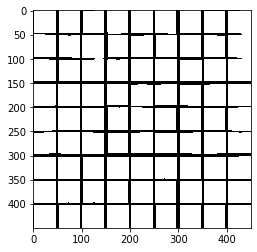

In [10]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 57, 5)

# Filter out all numbers and noise to isolate boxes
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 1000:
        cv2.drawContours(thresh, [c], -1, (0, 0, 0), -1)

# Fix horizontal and vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, vertical_kernel, iterations=9)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=4)

plt.imshow(thresh, cmap='gray_r')

### Sorting the contours and appending them to a 9x9 matrix

In [11]:
invert = 255 - thresh
cnts = cv2.findContours(invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts, _ = contours.sort_contours(cnts, method="top-to-bottom")

sudoku_rows = []
row = []
for (i, c) in enumerate(cnts, 1):
    area = cv2.contourArea(c)
    if area < 50000:
        row.append(c)
        if i % 9 == 0:
            cnts, _ = contours.sort_contours(row, method="left-to-right")
            sudoku_rows.append(cnts)
            row = []

squares = []
for row in sudoku_rows:
    for cc in row:
        x, y, w, h = cv2.boundingRect(cc)
        squares.append(image[y:y + h, x:x + w])

squares = np.reshape(squares, (-1, 9))
# Initialize a 9x9 matrix of zeros
board = np.zeros((9, 9))

---
## Example images

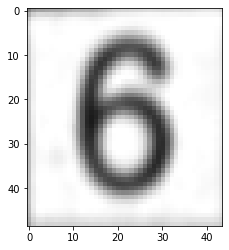

In [12]:
# Initial image
plt.imshow(squares[0][3])

A bit blurry...

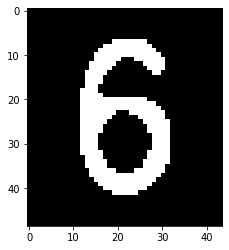

In [13]:
# Applying greyscale and thresh, and getting rid of noise
gray = cv2.cvtColor(squares[0][3], cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 57, 50)
denoise = ndimage.median_filter(thresh, 5)
plt.imshow(denoise, cmap='gray')


Now it looks pretty similar to the MNIST numbers!

---
## Creating the Board

In [14]:
mean_list = []

for x in squares:
    for box in x:
        gray = cv2.cvtColor(box, cv2.COLOR_BGR2GRAY)
        img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 57, 5)
        denoise = ndimage.median_filter(img, 5)
        white_pix_count = np.count_nonzero(denoise)
        mean_list.append(white_pix_count)

else:
    mean = np.mean(mean_list)

for col, x in enumerate(squares):
    for row, box in enumerate(x):
        gray = cv2.cvtColor(box, cv2.COLOR_BGR2GRAY)
        img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 57, 5)

        # Average pixel values in the image
        denoise = ndimage.median_filter(img, 5)
        white_pix_count = np.count_nonzero(denoise)

        # if there's enough white pixels, we know it has a number
        if white_pix_count > mean:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'

            model = Net()
            model.load_state_dict(torch.load('../training/results/model.pth', map_location=torch.device(device)))
            model.eval()

            p = transforms.Compose([transforms.Resize((28, 28)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])

            # Transform image to correct shape
            img = Image.fromarray(denoise)
            img = p(img)
            img = img.view(1, 28, 28)
            img = img.unsqueeze(0)

            # Put it in the CNN
            output = model(img)
            prediction = list(output.cpu()[0])

            # Append the prediction to the board
            board[col][row] = prediction.index(max(prediction))

print(board)

[[0. 0. 0. 6. 0. 4. 7. 0. 0.]
 [7. 0. 6. 0. 0. 0. 0. 0. 9.]
 [0. 0. 0. 0. 0. 5. 0. 8. 0.]
 [0. 7. 0. 0. 2. 0. 0. 9. 3.]
 [8. 0. 0. 0. 0. 0. 0. 0. 5.]
 [4. 3. 0. 0. 1. 0. 0. 7. 0.]
 [0. 5. 0. 2. 0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0. 0. 2. 0. 8.]
 [0. 0. 2. 3. 0. 1. 0. 0. 0.]]


---
## Solving the Board

In [15]:
solve(board)
print(board)

[[5. 8. 3. 6. 9. 4. 7. 2. 1.]
 [7. 1. 6. 8. 3. 2. 5. 4. 9.]
 [2. 9. 4. 1. 7. 5. 3. 8. 6.]
 [6. 7. 1. 5. 2. 8. 4. 9. 3.]
 [8. 2. 9. 7. 4. 3. 1. 6. 5.]
 [4. 3. 5. 9. 1. 6. 8. 7. 2.]
 [1. 5. 8. 2. 6. 7. 9. 3. 4.]
 [3. 6. 7. 4. 5. 9. 2. 1. 8.]
 [9. 4. 2. 3. 8. 1. 6. 5. 7.]]
